# This notebook outlines the creation of a MODFLOW-2005 model of Bear Spring

### As of 1/11/23, this notebook does not contain any implementation of CFP. That may be added to this notebook or formed in a second notebook at some point in the future.

In [80]:
import sys
import numpy as np
import numpy.ma as ma
import pandas as pd
import flopy
import flopy.utils.binaryfile as bf
from matplotlib import cm
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

### Pre-Process GIS files to convert them into MODFLOW-friendly csv files

In [81]:
# clip any txt files and convert them to .csv
run = False # to run each section, turn this variable to True
if run:        # if run is True, then run the following section
    
    #clip text file extent and convert to csv:
    files = ['model_bedr_topo10x10', 'model_DEM_10x10','Model_OSTP_Botm_10x10','model_OSTP_top_10x10']
    fig, ax = plt.subplots(1,len(files),figsize=(30,10))
    for i, f in enumerate(files):
        a = np.asarray(pd.read_csv(f+'.txt', header=None, delimiter = ',', na_values=0))
        print(np.shape(a))
        # all of my files are in m and have no Nan values, but may have some 0 value errors
        #no need to change array size (2/7/23) as all of my current input files have the same dimensions
        ax[i].imshow(a)
        ax[i].set_xlabel(f)
        np.savetxt(f+'.csv', a, delimiter=',')

In [82]:
import os
os.getcwd()

'C:\\Users\\Charlie\\MODFLOW\\Bear_Spring_ModflowCFP'

In [83]:
#Manually smooth out pumps in topogrpahic datasets first!!
#Make a smoother version of the topography in order to avioid convergence errors
run = False # turn to True in order to get this to run
if run:
    n = 3
    fig, ax = plt.subplots(1,n+1,figsize=(30,10))
    for i in range(n):
        print(i)
        topo = np.genfromtxt('model_bedr_topo10x10.csv', delimiter=',') # load the model topography from a csv file, this will be used to define the model grid
        ax[i].imshow(topo)
        ax[i].set_xlabel('smoothing='+str(i))
        w = 3
        nrow = np.shape(topo)[0]
        ncol = np.shape(topo)[1]
        smooth = np.full((nrow,ncol),500.)
        for row in range(nrow):
            for col in range(ncol):
                z = topo[row,col]
                try:
                    zavg = np.mean(topo[row-w:row+w,col-w,row+w])
                except:
                    try:
                        zavg = np.mean(topo[row-w:row,col-w,col])
                    except:
                        try:
                            zavg = np.mean(topo[row:row+w,col:col+w])
                        except:
                            print('averaging error')
                smooth[row,col] = zavg
        np.savetxt('model_bedr_topo10x10_smooth.csv',smooth, delimiter=',') #write new smoothed dem file
    ax[i+1].imshow(smooth)
    ax[i+1].set_xlabel('smoothing='+str(i))

In [84]:
#Make a curved bottom elevation array:
run = False #convert to True if you want to run this section of code
if run:
    topo = np.genfromtxt('model_DEM_10x10_smooth.csv', delimiter=',')
    zbot = topo - .02*(np.nanmax(topo)-topo)**1.4-250    #make a curved bottom surface
    np.savetxt('DEM_bottom.csv', zbot, delimiter=',')    #save the new bottom elevation
    #IMPORTANT: Data must have all strange elevation features smoothed out before proceeding

#smooth the bottom elevation array created above
run = False #convert to True if you want to run this section of code
if run:
    zbot = np.genfromtxt('DEM_bottom.csv', delimiter=',') + 45 #Load the manually corrected bedrock surface
    np.savetxt('zbot_DEM.csv',zbot, delimiter=',')   #save with new filename
    
    n = 2
    fig,ax = plt.subplots(1, n+1, figsize=(20,10))
    
    for i in range(n):
        print(i)
        zbot = np.genfromtxt('zbot_DEM.csv', delimiter=',')  #load the model topography from a csv file. It will then be used to define the model grid
        ax[i].imshow(zbot)
        ax[i].set_xlabel('smoothing='+ str(i))
        w=6
        nrow = np.shape(zbot)[0]
        ncol = np.shape(zbot)[1]
        smooth = np.full((nrow, ncol),500.)
        for row in range(nrow):
            for col in range(ncol):
                z = zbot[row,col]
                try:
                    zavg = np.mean(zbot[row-w:row+w,col-w,row+w])
                except:
                    try:
                        zavg = np.mean(zbot[row-w:row,col-w,col])
                    except:
                        try:
                            zavg = np.mean(zbot[row:row+w,col:col+w])
                        except:
                            print('averaging error')
                smooth[row,col] = zavg
        np.savetxt('zbot_DEM.csv', smooth, delimiter=',')   #overwrite with new smoothed array
    ax[i+1].imshow(smooth)
    ax[i+1].set_xlabel('smoothing='+str(i))
    

### Model Set Up

In [85]:
##Name:
modelname = "BearSpring"

##Units:
itmuni = 5                          #time unit: 1:sec, 2:min, 3:hr, 4:day, 5: year
lenuni = 2                          #length unit: 1:ft, 2:meters

# Zones: Load from csv files
topo = np.genfromtxt('model_DEM_10x10_smooth.csv', delimiter=',') #load the model topography from a csv file. It will then be used to define the model grid
ztop = topo.copy()    #make a copy of the topo array to use without messing up the original
bot = np.genfromtxt('model_bedr_topo10x10_smooth.csv', delimiter=',')   #load bottom elevation of model from csv file
zbot = bot.copy()
stream = np.genfromtxt('Bear_Creek_Reaches.csv', delimiter=',') ## stream reach map for bear creek
##Grids:
nrow = np.shape(topo)[0]
ncol = np.shape(topo)[1]
delr = 10
delc = 10
Lx = ncol*delr
Ly = nrow*delc

#Layers
#IMPORTANT: MODFLOW doesn't like thin low-K layers. To add a low-K layer to act as a confining unit,
#you MUST use something called a Quasi-3D confining bed. So, the number of layers in the model will be 1 less than the actual number of layers you want.
#Define which layer the confining bed goes below in laycbd. Define its thickness by adding a layer to botm.

#nlay = 3
nlay = 1    #for the first model pass, only using a single layer based on the surface DEM and the bedrock topography
layers = np.arange(nlay) #make array of layers
#botm = np.full((nlay+1,nrow,ncol),zbot)
botm = np.full((nlay,nrow,ncol),zbot)  #make an array of defualt cell bottom elevations for each cell in the model (dim:nlay,nrow,ncol)
zmiddle = zbot + (ztop-zbot)/2

#laytyp = [1,1]                               #whether each layer is confined or unconfined. 0:confined, 1: unconfined
#laycbd = [0,0]                              #whether each layer has a confining unit below it. 0: no, 1: yes
laytyp=1
laycbd=0

##Medium properties:
#Hydraulic conductivity:
#Kx and Ky:
#Kx = np.full((nlay,nrow,ncol),11.2)         #create array of default horizontal hydraulic conductivity (along rows)
#Kx[0,40:nrow,60:90] = 15.4                  #set Kx in top layer, along a north-south strip, to be higher (represents high-K alluvial sediments)
#Kx[1,:,:] = 9.0                             #set Kx in bottom layer to be lower (represents more compacted sediment)
K_ratio = 1                                 #ratio of Ky/Kx (aka Kcol/Krow) - if Kx=Ky, ratio=1

#assuming that the hydraulic conductivity is uniform for this first model test run
#Kz:
#Kz = np.full((nlay,nrow,ncol),7.7)        #create array of default vertical hydraulic conductivity (between layers, along z axis)
#Kz[0,40:nrow,60:90] = 1.52                #set Kz in top layer, along a north-south strip, to be higher (represents high-K alluvial sediments)
#Kz[1,:,:] = 4.3                           #set Kz in bottom layer to be lower (represents more consolidated sediment)
#Kzc = 3.25e-5                             #set Kz for confining layer

#Test
Kx=np.full((nlay,nrow,ncol),2.01)   #create an array of default horizontal hydraulic conductivity (along rows)
#Kx[1,:,:] = 1.0                             #set Kx in bottom layer to be lower (represents more compacted sediment)
Kz = np.full((nlay,nrow,ncol),0.012)        #create array of default vertical hydraulic conductivity (between layers, along z axis)
#Kz[1,:,:] = 1                           #set Kz in bottom layer to be lower (represents more consolidated sediment)
#Kzc = 1                             #set Kz for confining layer


#Storage, specfic yield
Ss = .0001   #storage coefficient (water released from compaction)
Sy = .01   #specific yield (water realeased from desaturation)


### Boundary Conditions

In [86]:
##Type of boundary at northern edge (spring location) of the model
northern_bound = 'constant head'   #choose from the following: 'constant head', 'constant flow', 'head dependent flow'

##No-Flow boundaries
#create arrays to indicate active cells and boundary conditions (ibound):
# if ibound = 0, inactive/no=flow/outside of watershed; if ibound > 0,active; if ibound <0, constant head.
ibound = np.full((nlay, nrow, ncol),0) # make array of zeros for default boundary conditions (dim:nlay, nrow, ncol)
ibound[:,2:278,2:362] = 1 # use valley boundaries to set active and inactive cells (all layers, all rows, all columns)
ibound[ibound!=1] = 0
 
##Constant head boundary conditions:
#create array of initial head values across the mdoel and at the boundaries
strt = np.full((nlay, nrow, ncol), np.min(ztop[-1,:]-1))   
strt = np.full((nlay, nrow, ncol), np.min(ztop-1))  #make array of initial head in all cells set to 10 m below lowest land surface elevation along southern boundary
strt= np.full((nlay,nrow,ncol), ztop-1)  #make an array of initial heads in all cells set to 50 m below the land surface elevation
if northern_bound == 'constant head':
    for col, active in enumerate(ibound[0,nrow-1,:]):     #for each column on the boundary, get the column and whether it is active or not
        if active == 1:
            ibound[:,nrow-1,col] = -1                   #replace southernmost row (slice all layers, active rows, last column) with -1 to indicate constant head

            
            
## head dependent flow bounary conditions:
if northern_bound =='head dependent flow':
    ghb_info=[]
    row = nrow-1
    for col, active in enumerate(ibound[0,row,:]):
        if active == 1:
            ghb_info.append([0, row, col, np.min(ztop[-1.:])-75, Kx[0,row,col]])
                            #lay, row,col,   head on boundary,    K on boundary]
            ghb_info.append([1,   row, col, np.min(ztop[-1,:])-300, Kx[1,row,col]])
    ghb_spd = {0:ghb_info}  #set boundary conditions for each stress period
                             

### Recharge

In [87]:
##Recharge
# not using values actually constrained by anything simply trying to implement recharge to get the model to work (2/7/23)
rech = np.full((280,364),1, dtype=float)
rech[0:20,:] = 0

### Evapotranspiration

In [88]:
##No ET data to input as of (2/7/23)

### Create Model objects

In [89]:
##Sections that rarely change:

##Outputs: we are telling the model which outputs to print
oc_spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...']
ipakcb = 53    #unit to save cell-by-cell outputs to

#Create the model objects and the objects for each package
#Note: running this section multiple times without changing filenames (see block above) will overwrite the existing 
#files & might generate a warning that existing packages are being replaced. This is fine.

#Create model object:
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')    #MODFLOW executable must be in same folder, named mf2005.exe
    
#Create objects for each package (see GHW1 notebook for details):
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, botm=botm, laycbd=laycbd, itmuni=itmuni, lenuni=lenuni)   #DIS (Discretization): creates model grid   
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)                      #BAS (Basic): assigns head boundaries
#lpf = flopy.modflow.ModflowLpf(mf, laytyp=laytyp, chani=0, hk=Kx, hani=K_ratio, vka=Kz, vkcb=Kcz, ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)                #LPF (Layer Property Flow): assigns flow props between cells
lpf = flopy.modflow.ModflowLpf(mf, laytyp=laytyp, chani=0, hk=Kx, hani=K_ratio, vka=Kz, ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)                #LPF (Layer Property Flow): assigns flow props between cells
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd, compact=True)         #OC (Output Control): Decides what outputs to save
pcg = flopy.modflow.ModflowPcg(mf, iter1=100, rclose=1e-2, hclose=1e-2, damp=0.5)  #PCG (Preconditioned Conjugate Gradient)
rch = flopy.modflow.mfrch.ModflowRch(mf, rech=rech)                               #RCH (Recharge)
#strm = flopy.modflow.mfstr.ModflowStr(mf, mxacts=nreach, nss=nseg, icalc=icalc, ipakcb=ipakcb,  istcb2=istcb2, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')  #STR (Stream)
#evt = flopy.modflow.mfevt.ModflowEvt(mf, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53)  #EVT (Evapotranspiration) - note: your computer may try to read this as an event log file
#wel = flopy.modflow.mfwel.ModflowWel(mf, stress_period_data=well_spd)             #WEL (Well)  
if northern_bound == 'head dependent flow':
    ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=ghb_spd)                   #GHB (General Head Boundary)

### Display summary of model inputs

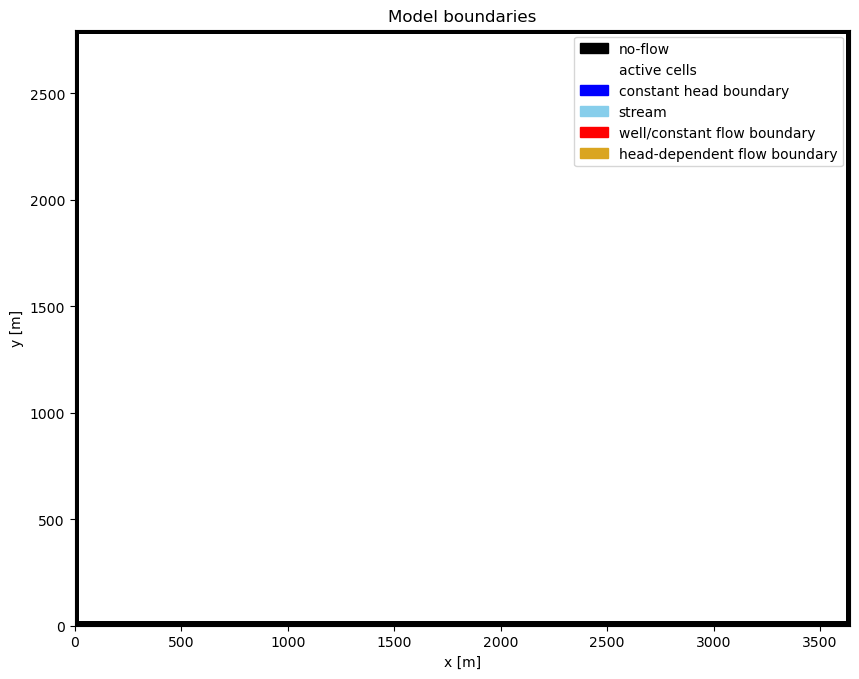

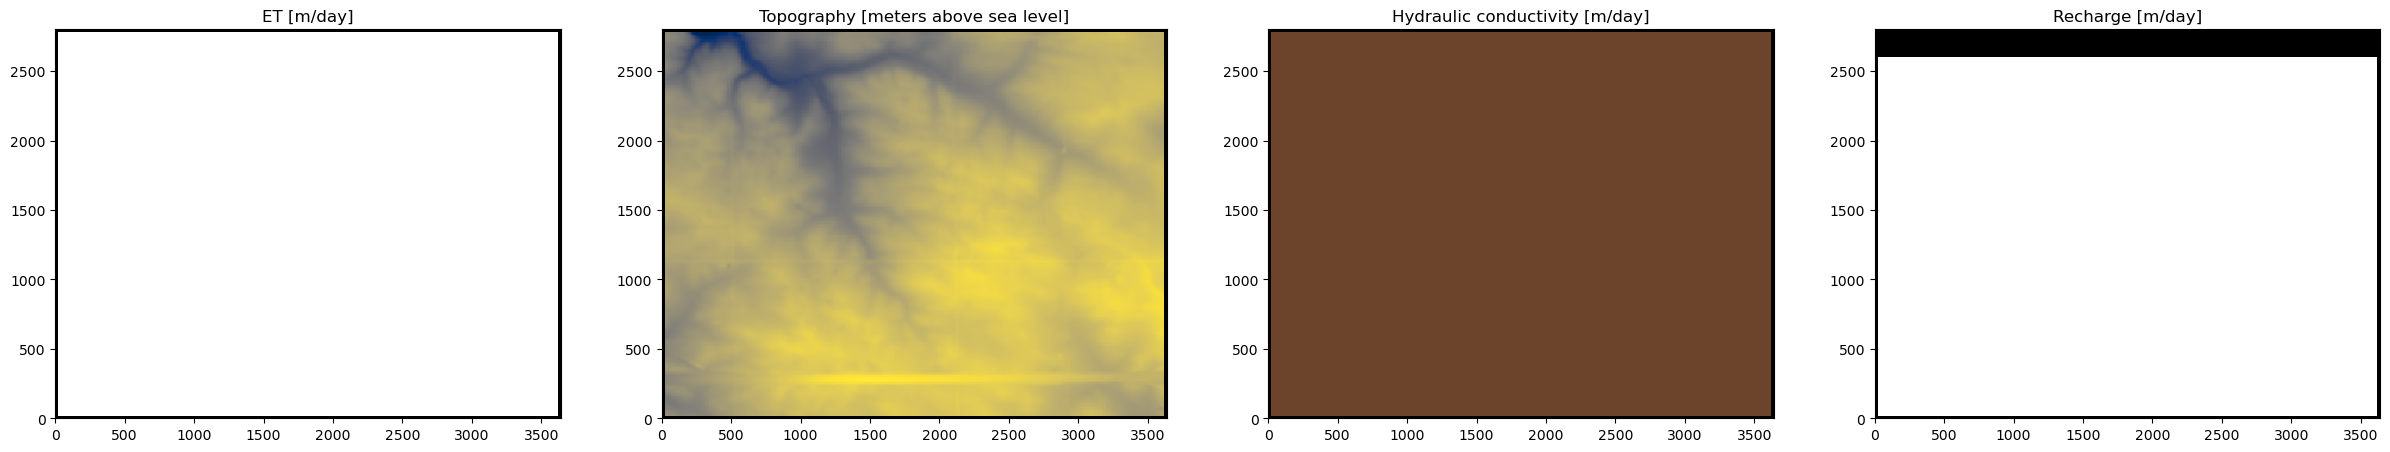

In [90]:
#Plot model boundaries and hydraulic properties:
f,ax = plt.subplots(1,1,figsize=(10,10))
ax.set_aspect('equal')
ax.set_title('Model boundaries')      #set first subplot title
m = flopy.plot.PlotMapView(model=mf, ax=ax, layer=0)     #create model map object on first subplot axes
#grid = m.plot_grid(colors='gray')                           #plot model grid
try: w = m.plot_bc('WEL', color='red', plotAll=True)              #plot wells
except: pass
try: s = m.plot_bc('STR', color='skyblue')                        #plot stream
except: pass
try: g = m.plot_bc('GHB', color='goldenrod')
except: pass
bc = m.plot_ibound()                                        #plot boundary conditions
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.legend(handles=[matplotlib.patches.Patch(color='black',label='no-flow'),      #add legend manually
                      matplotlib.patches.Patch(color='white',label='active cells'),
                      matplotlib.patches.Patch(color='blue',label='constant head boundary'),
                      matplotlib.patches.Patch(color='skyblue', label='stream'),
                      matplotlib.patches.Patch(color='red', label='well/constant flow boundary'),
                      matplotlib.patches.Patch(color='goldenrod', label='head-dependent flow boundary')
                    ])

f,ax = plt.subplots(1,4,figsize=(30,10))                    #create new figure and axes with subplots
m = flopy.plot.PlotMapView(model=mf, ax=ax[0], layer=0)     #create model map object on second subplot axes
ax[0].set_aspect('equal')
ax[0].set_title('ET [m/day]')                               #set first subplot title
#k = m.plot_array(ET, cmap='Greens', vmin=0)                   #plot array of horizontal hydraulic conductivities (set range manually to control colors)
bc = m.plot_ibound()                                        #plot boundary conditions

ax[1].set_title('Topography [meters above sea level]')      #set first subplot title
ax[1].set_aspect('equal')
m = flopy.plot.PlotMapView(model=mf, ax=ax[1], layer=0)     #create model map object on first subplot axes
t = m.plot_array(ztop, cmap='cividis')   #plot topography array
bc = m.plot_ibound()                                        #plot boundary conditions

m = flopy.plot.PlotMapView(model=mf, ax=ax[2], layer=0)     #create model map object on second subplot axes
ax[2].set_aspect('equal')
ax[2].set_title('Hydraulic conductivity [m/day]')           #set first subplot title
k = m.plot_array(Kx, cmap='copper', vmin=-100, vmax=200)    #plot array of horizontal hydraulic conductivities (set range manually to control colors)
bc = m.plot_ibound()                                        #plot boundary conditions

m = flopy.plot.PlotMapView(model=mf, ax=ax[3], layer=0)     #create model map object on second subplot axes
ax[3].set_aspect('equal')
ax[3].set_title('Recharge [m/day]')                         #set first subplot title
k = m.plot_array(rech, cmap='bone', vmin=0)                         #plot array of horizontal hydraulic conductivities (set range manually to control colors)
bc = m.plot_ibound()                                        #plot boundary conditions

### Cross-Section View

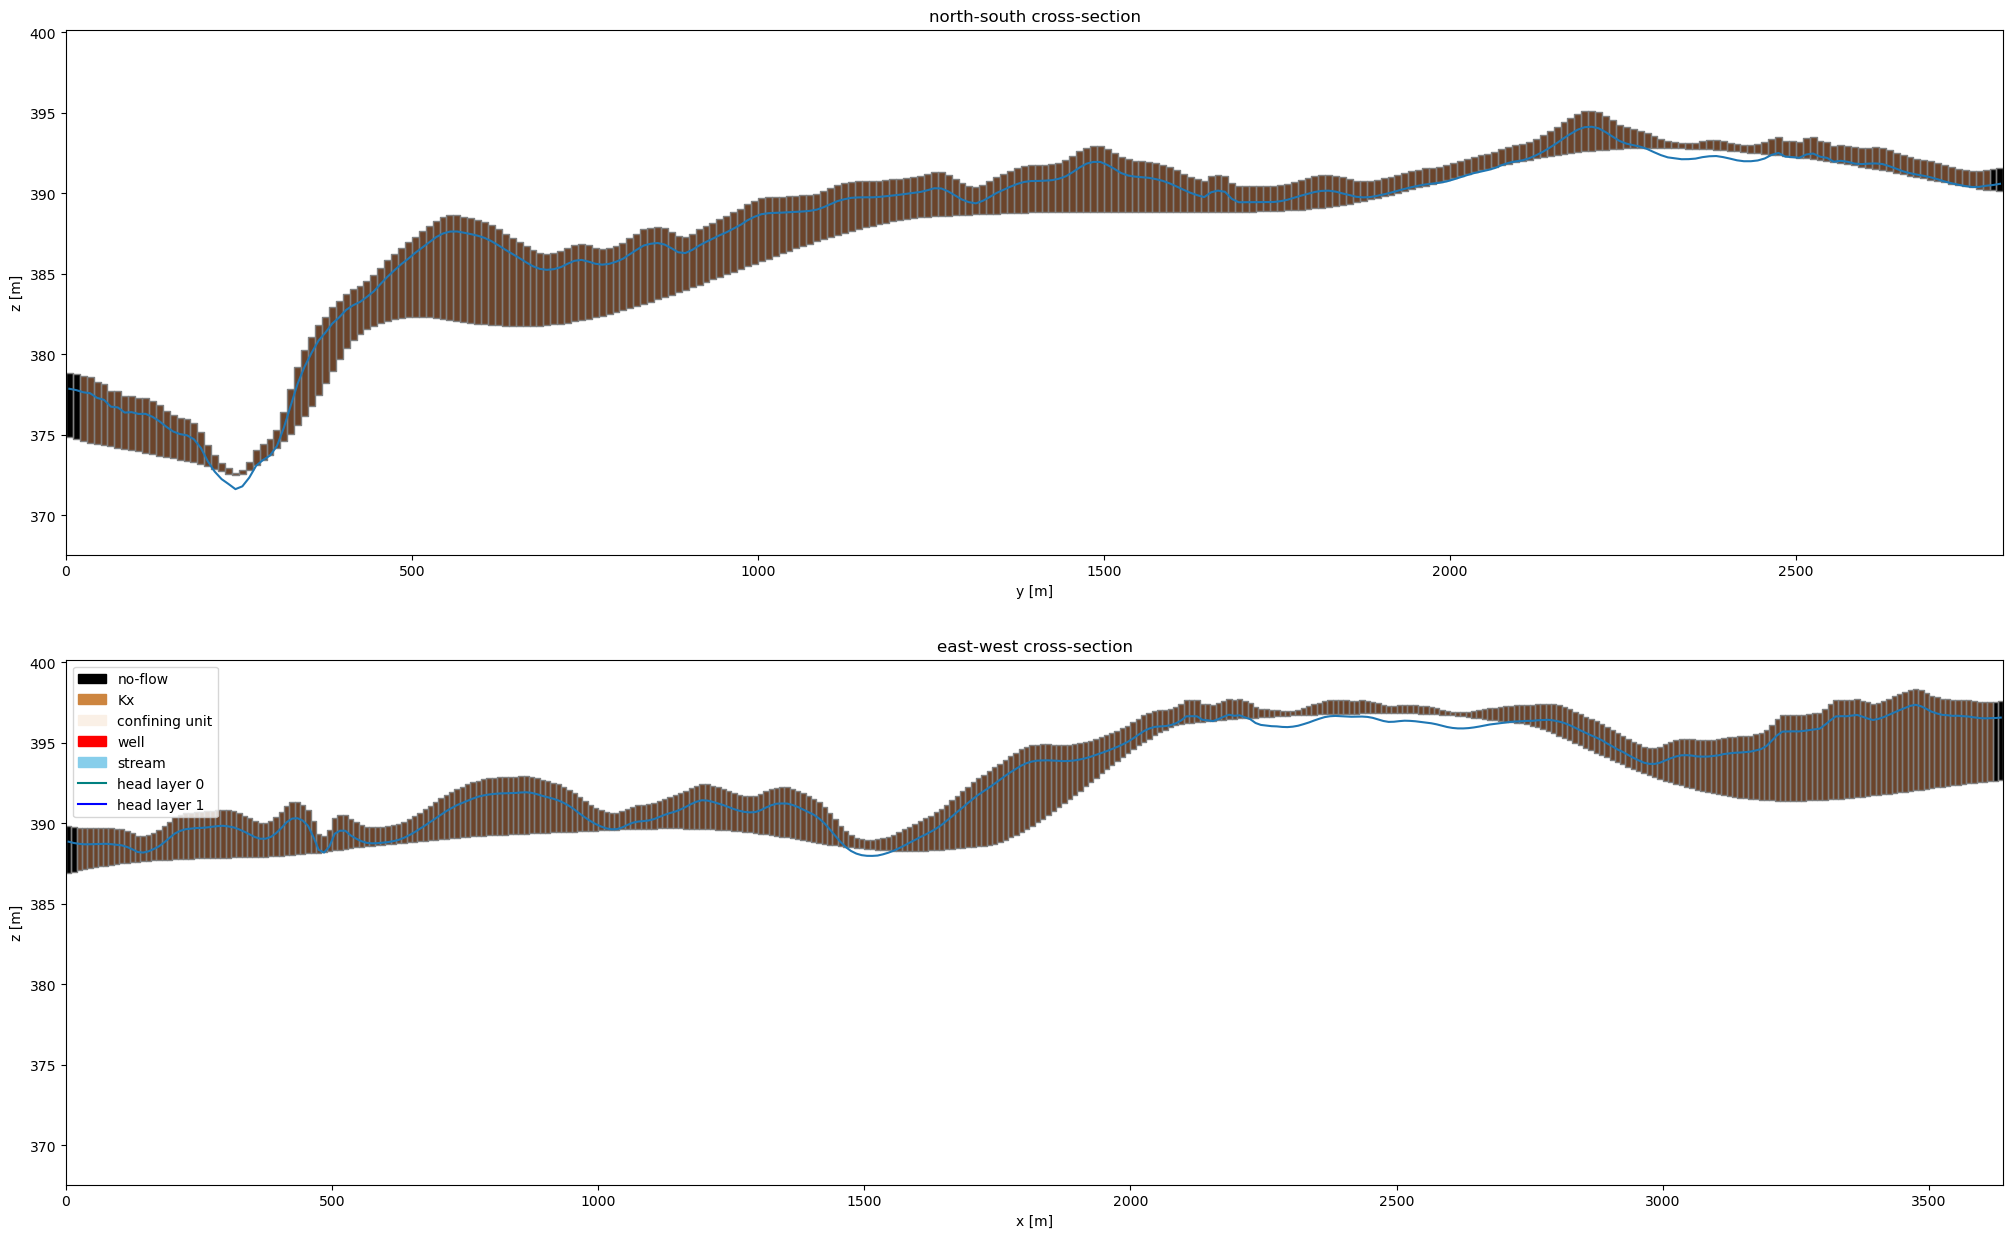

In [91]:
#Plot cross-section view of model:
row = 170     #row to plot on
col = 65      #column to plot on

#South-North:
f,ax = plt.subplots(2,1, figsize=(25,15))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'column': col})  #plot cross-section along given column (change column # to see different locations)
k  = xsec.plot_array(Kx, cmap='copper', vmin=-100, vmax=200)                 #plot horizontal K as an array, with color range set manually to be consistent with other plots
ax[0].plot(np.arange(delr/2,Ly,delr), strt[0,:,col])                         #plots starting heads as a line
#ax[0].plot(np.arange(delr/2,Ly,delr), strt[1,:,col], color='blue')           #plots starting heads as a line
bc = xsec.plot_ibound()                                                      #plot boundary conditions
try: s  = xsec.plot_bc("STR", color='skyblue')                                    #plot stream
except: pass
try: w = xsec.plot_bc("WEL", color='red')                                         #plot wells (will only show wells at displayed column)
except: pass
try: g = m.plot_bc('GHB', color='goldenrod')                                      #plot head-dependent flow
except: pass
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('north-south cross-section')

#East-West:
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': row})    #plot cross-ection along stream row
k  = xsec.plot_array(Kx, cmap='copper', vmin=-100, vmax=200)                #plot heads as an array, with color range set manually to be consistent with other plots
ax[1].plot(np.arange(delc/2,Lx,delc), strt[0,row,:])                        #plots starting heads as a line
#ax[1].plot(np.arange(delc/2,Lx,delc), strt[1,row,:], color='blue')          #plots starting heads as a line
bc = xsec.plot_ibound()                                                     #plot boundary conditions
try: s  = xsec.plot_bc("STR", color='skyblue')                                    #plot stream
except: pass
try: w = xsec.plot_bc("WEL", color='red')                                        #plot wells (will only show wells at displayed row)
except: pass
try: g = m.plot_bc('GHB', color='goldenrod')                                     #plot head-dependent flow
except: pass
g  = xsec.plot_grid()                                                       #plot grid
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('east-west cross-section')

plt.legend(handles=[matplotlib.patches.Patch(color='black',label='no-flow'),
                    matplotlib.patches.Patch(color='peru',label='Kx'),
                    matplotlib.patches.Patch(color='linen',label='confining unit'),
                    matplotlib.patches.Patch(color='red',label='well'),
                    matplotlib.patches.Patch(color='skyblue',label='stream'),
                    matplotlib.lines.Line2D([],[], color='teal',label='head layer 0'),
                    matplotlib.lines.Line2D([],[], color='blue',label='head layer 1')]) #add legend manually

## Run the Model

The code in this section will change very little

In [92]:
#Write MODFLOW input files:
mf.write_input()

#Run MODFLOW
success, buff = mf.run_model()  #you should see "normal termination of simulation" printed below

FloPy is using the following executable to run the model: .\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: BearSpring.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/02/07 16:46:07

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
